# Digit Recognizer Data Preparation Notebook

In this [Kaggle competition](https://www.kaggle.com/competitions/digit-recognizer/overview) 

>MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

>In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

## Install necessary packages

We use the requirement.txt file to list all the dependencies and then run pip install for the requirements.

In [1]:

%pip install -r requirements.txt --user --quiet

Note: you may need to restart the kernel to use updated packages.


If this is the first time running this file, restart the kernel.

## Imports

In this section, we import the packages needed in this example.  It is good practice to gather your imports into a single place.  

In [2]:
# Imports
import sys, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile


from netapp_dataops.k8s import cloneJupyterLab, createJupyterLab, deleteJupyterLab, \
listJupyterLabs, createJupyterLabSnapshot, listJupyterLabSnapshots, restoreJupyterLabSnapshot, \
cloneVolume, createVolume, deleteVolume, listVolumes, createVolumeSnapshot, \
deleteVolumeSnapshot, listVolumeSnapshots, restoreVolumeSnapshot

## The Data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

- Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. 
- Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.





In [3]:
TRAIN_CSV_ZIP = 'train.csv.zip'
TEST_CSV_ZIP = 'test.csv.zip'

In [ ]:
ROOT = '/home/jovyan'
assert os.path.exists(ROOT)

In [4]:
DATA_ROOT = '/home/jovyan/data'
assert os.path.exists(DATA_ROOT)

In [6]:
# Training data paths
DATA_TRAIN_ROOT = os.path.join(DATA_ROOT,'train')
#os.makedirs(DATA_TRAIN_ROOT, exist_ok=True)
#assert os.path.exists(DATA_TRAIN_ROOT)
DATA_TRAIN_FILE = os.path.join(DATA_TRAIN_ROOT,'train.csv')
# Testing data paths
DATA_TEST_ROOT = os.path.join(DATA_ROOT,'test')
#os.makedirs(DATA_TEST_ROOT, exist_ok=True)
#assert os.path.exists(DATA_TEST_ROOT)
DATA_TEST_FILE = os.path.join(DATA_TEST_ROOT,'test.csv')
# Evaluation data paths
DATA_EVAL_ROOT = os.path.join(DATA_ROOT,'eval')
#os.makedirs(DATA_EVAL_ROOT, exist_ok=True)
#assert os.path.exists(DATA_EVAL_ROOT)
DATA_EVAL_FILE = os.path.join(DATA_EVAL_ROOT,'eval.csv')
# Production data paths
DATA_PROD_ROOT = os.path.join(DATA_ROOT,'prod')
#os.makedirs(DATA_PROD_ROOT, exist_ok=True)
#assert os.path.exists(DATA_PROD_ROOT)
DATA_PROD_FILE = os.path.join(DATA_PROD_ROOT,'prod.csv')

In [7]:
with ZipFile('train.csv.zip', 'r') as zip:
    zip.extractall(ROOT)
zip.close()
RAW_TRAIN_ROOT = os.path.join(ROOT,'train.csv')
assert os.path.exists(RAW_TRAIN_ROOT)

In [8]:
# split the training data into two parts
# 75% for training
# 25% for (cross)validation
RAW_TRAIN_DF1 = pd.read_csv(RAW_TRAIN_ROOT)
PART_75 = RAW_TRAIN_DF1.sample(frac =0.75)
PART_25 = RAW_TRAIN_DF1.drop(PART_75.index)

In [9]:
# Save the split data sets to files
PART_75.to_csv(DATA_TRAIN_FILE, encoding='utf-8', index=False)
PART_25.to_csv(DATA_EVAL_FILE, encoding='utf-8', index=False)

In [10]:
with ZipFile(TEST_CSV_ZIP, 'r') as zip:
    zip.extractall(ROOT)
zip.close()

RAW_TEST_ROOT = os.path.join(ROOT,'test.csv')
assert os.path.exists(RAW_TEST_ROOT)

In [11]:
# Split the test.csv into 2 parts
# 50% for Test
# 50% for Prod
RAW_TEST_DF1 = pd.read_csv(RAW_TEST_ROOT)
PART_50 = RAW_TEST_DF1.sample(frac =0.5)
PART_50_2 = RAW_TEST_DF1.drop(PART_50.index)

In [12]:
# Save the split data sets to files
PART_50.to_csv(DATA_TEST_FILE, encoding='utf-8', index=False)
PART_50_2.to_csv(DATA_PROD_FILE, encoding='utf-8', index=False)

In [13]:
# Loading dataset into pandas 
TRAIN_DF = pd.read_csv(DATA_TRAIN_FILE)
TEST_DF = pd.read_csv(DATA_TEST_FILE)
EVAL_DF = pd.read_csv(DATA_EVAL_FILE)
PROD_DF = pd.read_csv(DATA_PROD_FILE)

## Training Data

Let us now explore the data
To this end, we use the pandas `head` method to visualize the 1st five rows of our data set.

In [14]:
TRAIN_DF.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
TRAIN_DF.shape

(31500, 785)

In [16]:
# Spilt the training data into so the label is in TRAIN_Y and TRAIN_X doesn't include the label
TRAIN_X = TRAIN_DF.drop('label', axis=1)
TRAIN_Y = TRAIN_DF.label

# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
TRAIN_X = TRAIN_X.values.reshape(-1,28,28,1)


# Normalize the data
# Each pixel has a value between 0-255. Here we divide by 255, to get values from 0-1
TRAIN_X = TRAIN_X / 255.0

In [17]:
TRAIN_X.shape

(31500, 28, 28, 1)

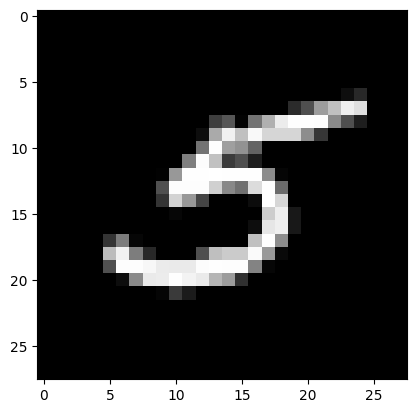

correct number: 5


In [18]:
# Visualize single data instances

img_no = 31499 # Change the number to display other examples

first_number = TRAIN_X[img_no]
plt.imshow(first_number, cmap='gray') # Visualize the numbers in gray mode
plt.show()
print(f"correct number: {TRAIN_Y[img_no]}")

## Evaluation Data

In [19]:
EVAL_DF.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
EVAL_DF.shape

(10500, 785)

In [21]:
# Spilt the training data into so the label is in TRAIN_Y and TRAIN_X doesn't include the label
EVAL_X = EVAL_DF.drop('label', axis=1)
EVAL_Y = EVAL_DF.label

# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
EVAL_X = EVAL_X.values.reshape(-1,28,28,1)


# Normalize the data
# Each pixel has a value between 0-255. Here we divide by 255, to get values from 0-1
EVAL_X = EVAL_X / 255.0

In [22]:
EVAL_X.shape

(10500, 28, 28, 1)

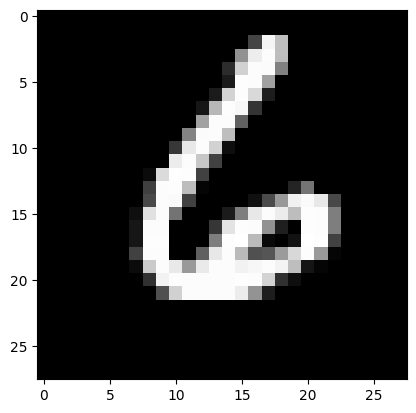

correct number: 6


In [23]:
# Visualize single data instances

img_no = 10499 # Change the number to display other examples

first_number = EVAL_X[img_no]
plt.imshow(first_number, cmap='gray') # Visualize the numbers in gray mode
plt.show()
print(f"correct number: {EVAL_Y[img_no]}")

## Testing Data

In [24]:
TEST_DF.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
TEST_DF.shape

(14000, 784)

In [26]:
TEST_X = TEST_DF

# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
TEST_X = TEST_X.values.reshape(-1,28,28,1)


# Normalize the data
# Each pixel has a value between 0-255. Here we divide by 255, to get values from 0-1
TEST_X = TEST_X / 255.0

In [27]:
TEST_X.shape

(14000, 28, 28, 1)

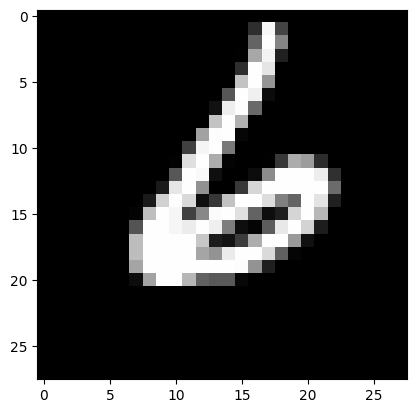

In [28]:
# Visualize single data instances

img_no = 13999 # Change the number to display other examples

first_number = TEST_X[img_no]
plt.imshow(first_number, cmap='gray') # Visualize the numbers in gray mode
plt.show()


## Production Data

In [29]:
PROD_DF.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
PROD_DF.shape

(14000, 784)

In [31]:
PROD_X = PROD_DF

# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
PROD_X = PROD_X.values.reshape(-1,28,28,1)


# Normalize the data
# Each pixel has a value between 0-255. Here we divide by 255, to get values from 0-1
PROD_X = PROD_X / 255.0

In [32]:
PROD_X.shape

(14000, 28, 28, 1)

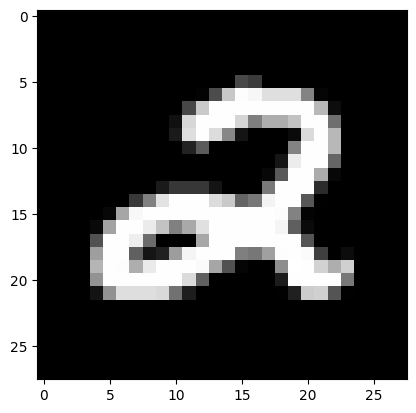

In [33]:
# Visualize single data instances

img_no = 13999 # Change the number to display other examples

first_number = PROD_X[img_no]
plt.imshow(first_number, cmap='gray') # Visualize the numbers in gray mode
plt.show()


## Create Snapshots of the 4 Data Volumes

In [34]:
USER_NAMESPACE = "kubeflow-user-example-com"

In [ ]:
# Create a VolumeSnapshot for the volume attached to the 
#   PersistentVolumeClaim (PVC) named in the varialbe DATA_TRAIN_ROOT in namespace in USER_NAMESPACE.
createVolumeSnapshot(pvcName=DATA_TRAIN_ROOT, namespace=USER_NAMESPACE, printOutput=True)

/tmp/ipykernel_508/3737601675.py:3: DeprecationWarning: Function createVolumeSnapshot is deprecated.
  createVolumeSnapshot(pvcName=DATA_TRAIN_ROOT, namespace=USER_NAMESPACE, printOutput=True)


Creating VolumeSnapshot 'ntap-dsutil.20230418231234' for PersistentVolumeClaim (PVC) '/home/jovyan/data/train' in namespace 'kubeflow-user-example-com'.
VolumeSnapshot 'ntap-dsutil.20230418231234' created. Waiting for Trident to create snapshot on backing storage.


In [ ]:
# Create a VolumeSnapshot for the volume attached to the 
#   PersistentVolumeClaim (PVC) named in the varialbe DATA_TEST_ROOT in namespace in USER_NAMESPACE.
createVolumeSnapshot(pvcName=DATA_TEST_ROOT, namespace=USER_NAMESPACE, printOutput=True)

In [ ]:
# Create a VolumeSnapshot for the volume attached to the 
#   PersistentVolumeClaim (PVC) named in the variable DATA_EVAL_ROOT in namespace in USER_NAMESPACE.
createVolumeSnapshot(pvcName=DATA_EVAL_ROOT, namespace=USER_NAMESPACE, printOutput=True)

In [ ]:
# Create a VolumeSnapshot for the volume attached to the 
#   PersistentVolumeClaim (PVC) named in the variable DATA_PROD_ROOT in namespace in USER_NAMESPACE.
createVolumeSnapshot(pvcName=DATA_PROD_ROOT, namespace=USER_NAMESPACE, printOutput=True)

In [ ]:
#List the VolumeSnapshots for the namespace
listVolumeSnapshots(namespace=USER_NAMESPACE)